This Notebook contains an example of using the given VaLLA implementation over 1D regression datasets.

# Imports

In [50]:
# Notebook reload options
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:

# Global Imports
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.vq import kmeans2

# Local Imports
sys.path.append("..")
from utils.pytorch_learning import fit_map, fit
from src.valla import VaLLARegression, VaLLARegressionBackend
from utils.metrics import Regression
from src.ella import ELLA_Regression
from utils.models import get_mlp, create_ad_hoc_mlp
from laplace import Laplace

from utils.dataset import get_dataset

# Experimental settings

Theese are the parameters that determine the experiments. Most of these values are set to their default value. Please refer to `utils/process_flass.py` to know more about each parameter.

In [52]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

Set seed for reproductibility.

In [53]:
torch.manual_seed(params["seed"])

Load Dataset and desired split.

In [54]:
dataset = get_dataset("synthetic")
train_dataset, val_dataset, test_dataset = dataset.get_split()

Number of samples:  76
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


Create Data loaders for training and test partitions.

In [55]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

(-7.0, 7.0)

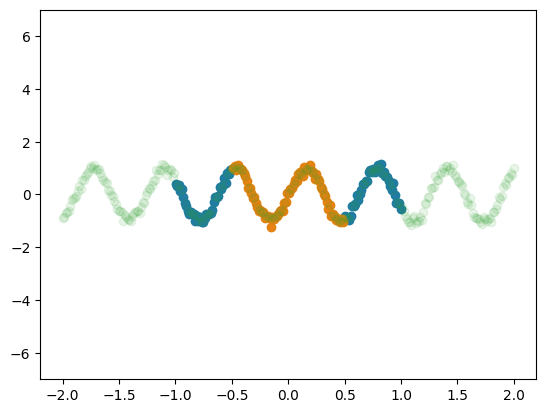

In [56]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")


plt.scatter(val_dataset.inputs, 
                val_dataset.targets, 
                label="Val points")


plt.scatter(test_dataset.inputs, 
                test_dataset.targets, 
                label="Test points", alpha=0.1)

plt.ylim(-7. ,7)


# MAP Learning

In [57]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.AdamW(f.parameters(), lr=params["MAP_lr"], weight_decay=0.1)
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=10000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training :   0%|          | 40/10000 [00:00<00:25, 393.15 iteration/s]

Training : 100%|██████████| 10000/10000 [00:24<00:00, 401.64 iteration/s]


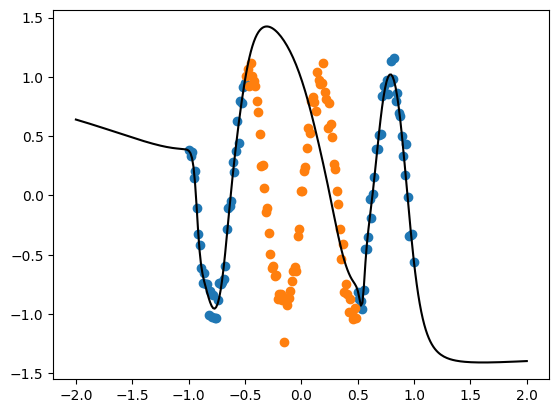

In [58]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")


plt.scatter(val_dataset.inputs, 
                val_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

In [59]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

#la.optimize_prior_precision(method='CV', val_loader=val_loader)

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


In [60]:
def distribution_plot(model_predictive, name = None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy() + np.exp(log_variance)
    std = np.sqrt(var).flatten()
    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.scatter(val_dataset.inputs, 
                    val_dataset.targets, 
                    color = "tomato")


    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    #plt.axis('off')
    plt.ylim(-7. ,7)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("../demos/plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

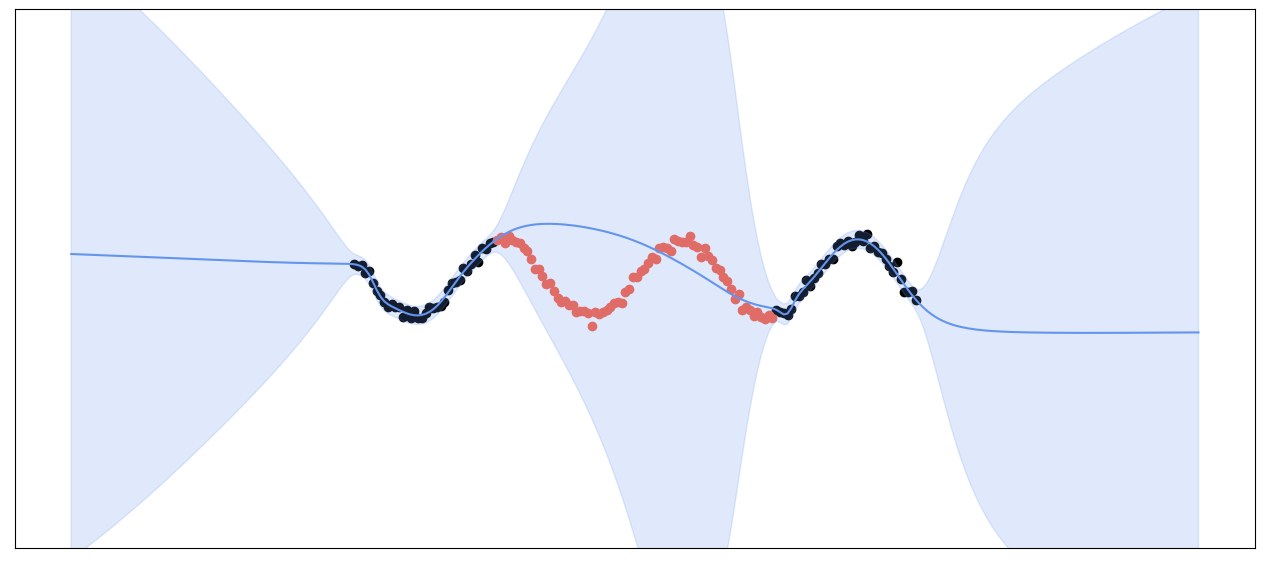

In [61]:
distribution_plot(la._glm_predictive_distribution, "LLA_val")

# ELLA

In [62]:
Ms = [5, 10, 20, 50]

Training : 100%|██████████| 1/1 [00:00<00:00, 55.54iteration/s]


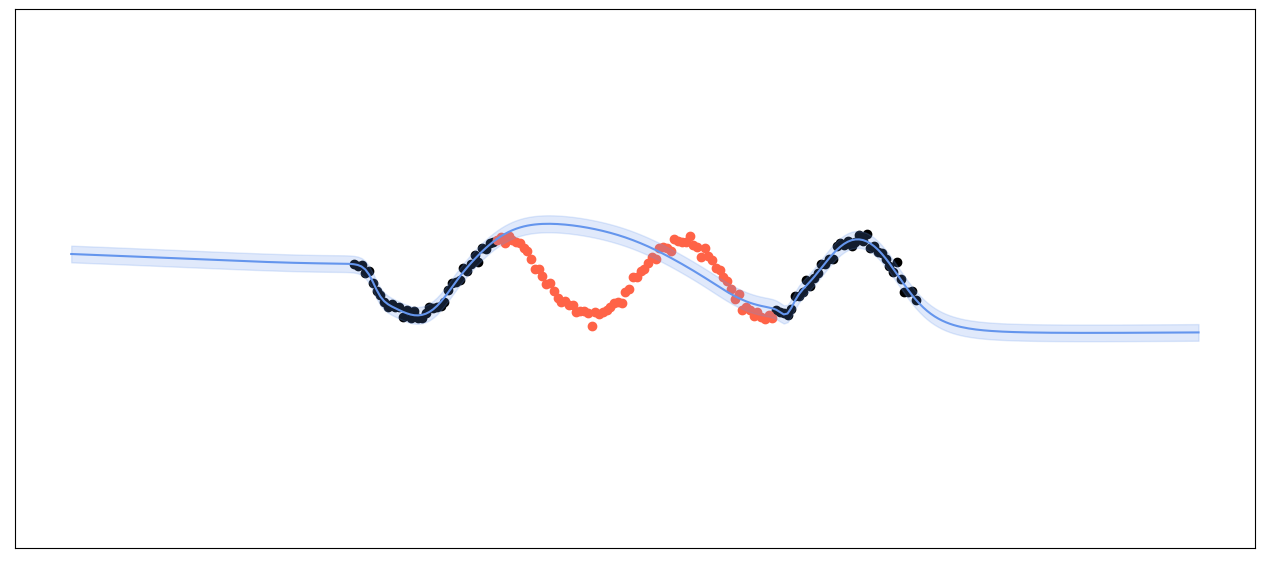

Training :   0%|          | 0/1 [00:00<?, ?iteration/s]

Training : 100%|██████████| 1/1 [00:00<00:00, 34.47iteration/s]


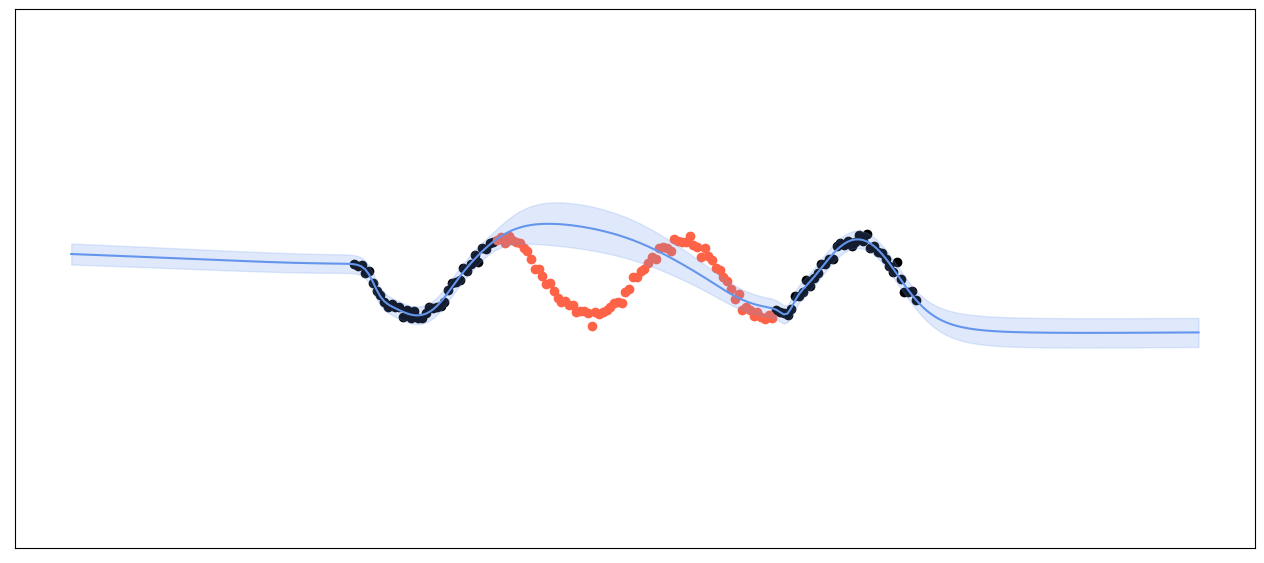

Training : 100%|██████████| 1/1 [00:00<00:00, 72.13iteration/s]


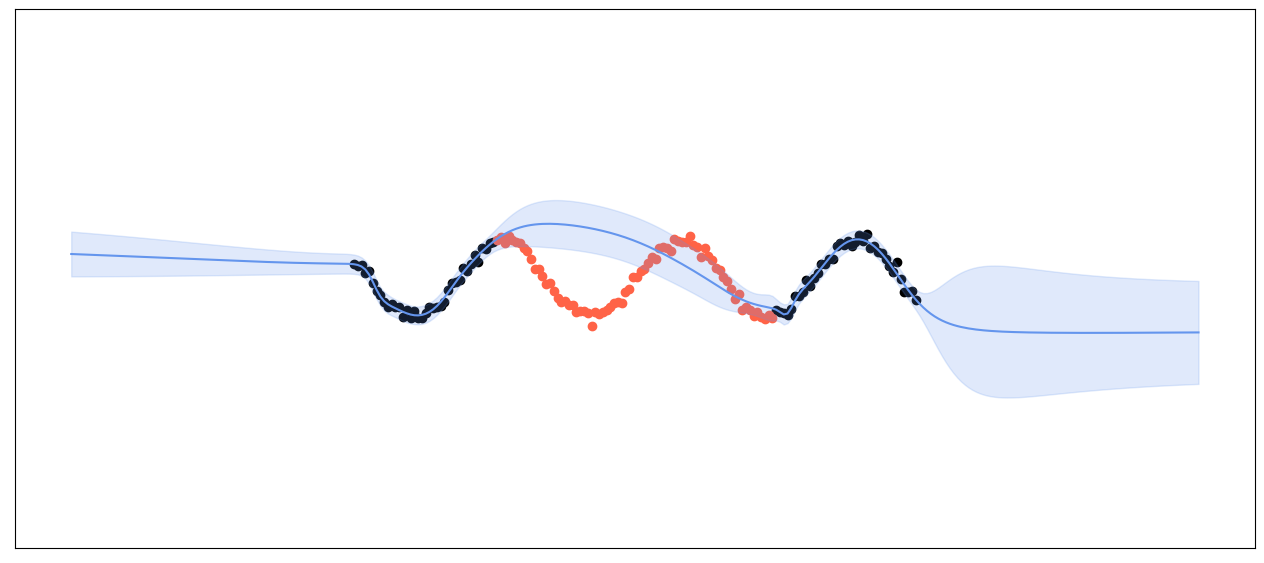

Training : 100%|██████████| 1/1 [00:00<00:00, 44.25iteration/s]


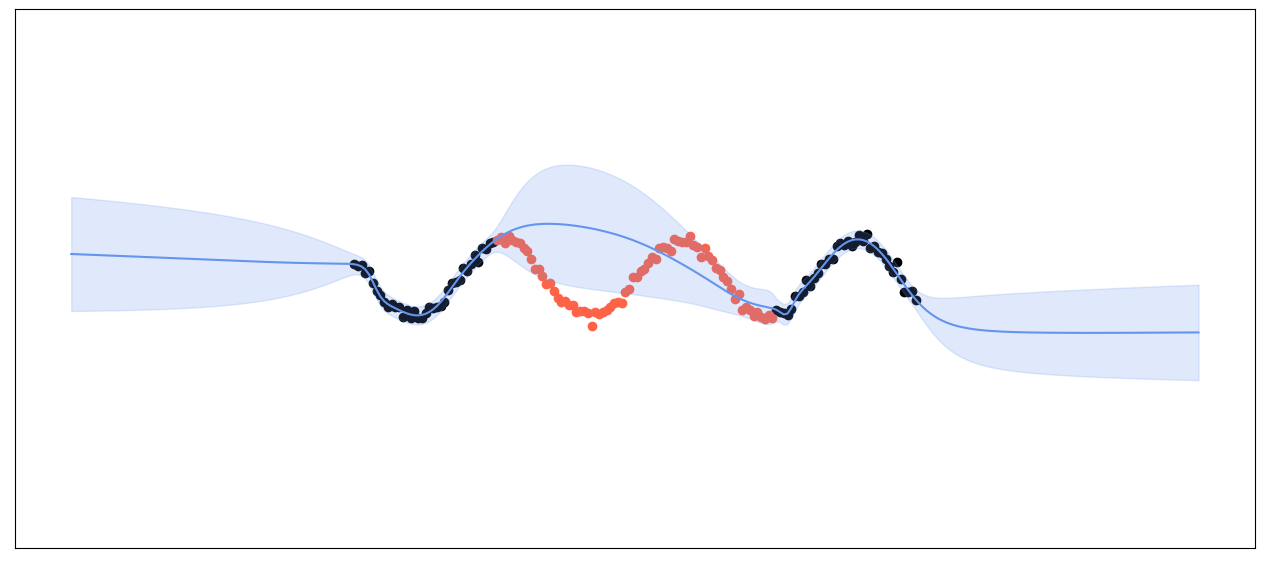

In [63]:
for m in Ms:
    ella = ELLA_Regression(
        create_ad_hoc_mlp(f),
        f.output_size,
        m,
        min(m, 20),
        prior_std=prior_std,
        log_variance = log_variance,
        seed=params["seed"],
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    ella.fit_loader_val(
            torch.tensor(train_dataset.inputs, 
                         device=params["device"], 
                         dtype=params["dtype"]),
            torch.tensor(train_dataset.targets,
                         device=params["device"], 
                         dtype=params["dtype"]),
            train_loader,
            val_loader = val_loader,
            verbose = True,
        )
    distribution_plot(ella.predict_f, "ELLA_val_M={}".format(m))

# VaLLA

Define DVIP model.

Backend or not can be used, in case of using the backend change `VaLLARegression` for `VaLLARegressionBackpack` and un-comment the backend line.

In [64]:
from src.backpack_interface import BackPackInterface
backend = BackPackInterface(f, train_dataset.output_dim)

Initializing inducing classes with 1 different classes
Iteration  0
Validation NLL: 3.27629017829895
Iteration  100
Validation NLL: 3.1530568599700928
Iteration  200
Validation NLL: 3.0723259449005127
Iteration  300
Validation NLL: 3.000790596008301
Iteration  400
Validation NLL: 2.936769485473633
Iteration  500
Validation NLL: 2.878833532333374
Iteration  600
Validation NLL: 2.8259105682373047
Iteration  700
Validation NLL: 2.7771809101104736
Iteration  800
Validation NLL: 2.732004404067993
Iteration  900
Validation NLL: 2.689873218536377
Iteration  1000
Validation NLL: 2.650378465652466
Iteration  1100
Validation NLL: 2.6131856441497803
Iteration  1200
Validation NLL: 2.578019380569458
Iteration  1300
Validation NLL: 2.544649362564087
Iteration  1400
Validation NLL: 2.5128817558288574
Iteration  1500
Validation NLL: 2.4825520515441895
Iteration  1600
Validation NLL: 2.453519105911255
Iteration  1700
Validation NLL: 2.425662040710449
Iteration  1800
Validation NLL: 2.3988752365112305


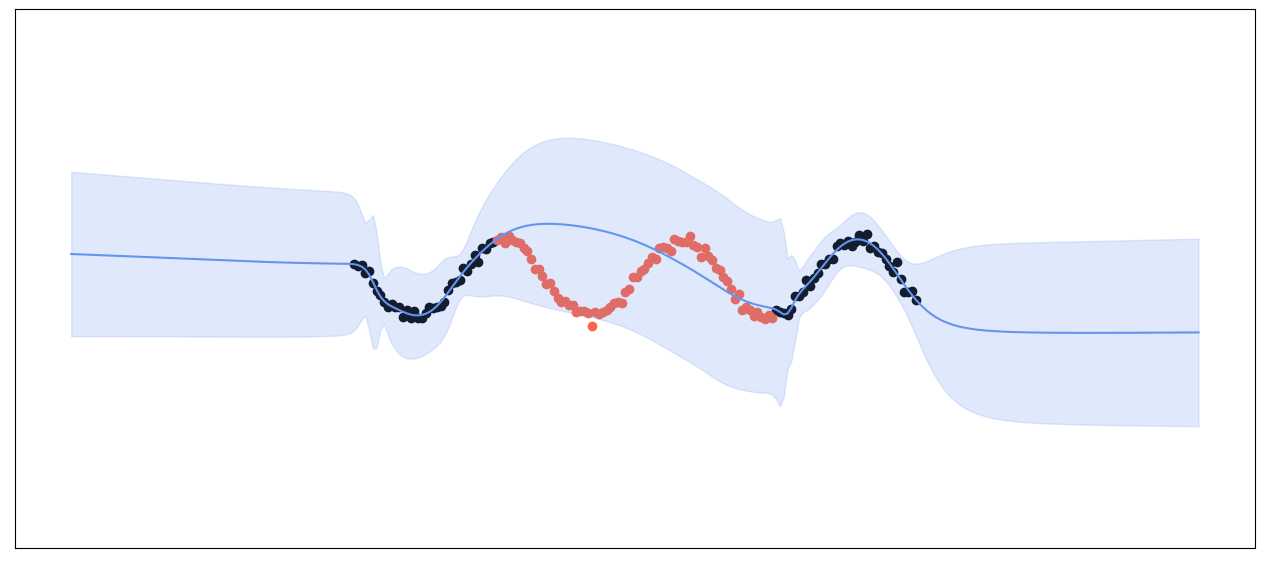

Initializing inducing classes with 1 different classes
Iteration  0
Validation NLL: 3.050294876098633
Iteration  100
Validation NLL: 2.8019518852233887
Iteration  200
Validation NLL: 2.730830430984497
Iteration  300
Validation NLL: 2.660829782485962
Iteration  400
Validation NLL: 2.53058123588562
Iteration  500
Validation NLL: 2.462397336959839
Iteration  600
Validation NLL: 2.427299737930298
Iteration  700
Validation NLL: 2.392965316772461
Iteration  800
Validation NLL: 2.3596372604370117
Iteration  900
Validation NLL: 2.327408790588379
Iteration  1000
Validation NLL: 2.2963058948516846
Iteration  1100
Validation NLL: 2.2663161754608154
Iteration  1200
Validation NLL: 2.2374048233032227
Iteration  1300
Validation NLL: 2.2095253467559814
Iteration  1400
Validation NLL: 2.1826257705688477
Iteration  1500
Validation NLL: 2.1566531658172607
Iteration  1600
Validation NLL: 2.13155460357666
Iteration  1700
Validation NLL: 2.1072793006896973
Iteration  1800
Validation NLL: 2.0837795734405518

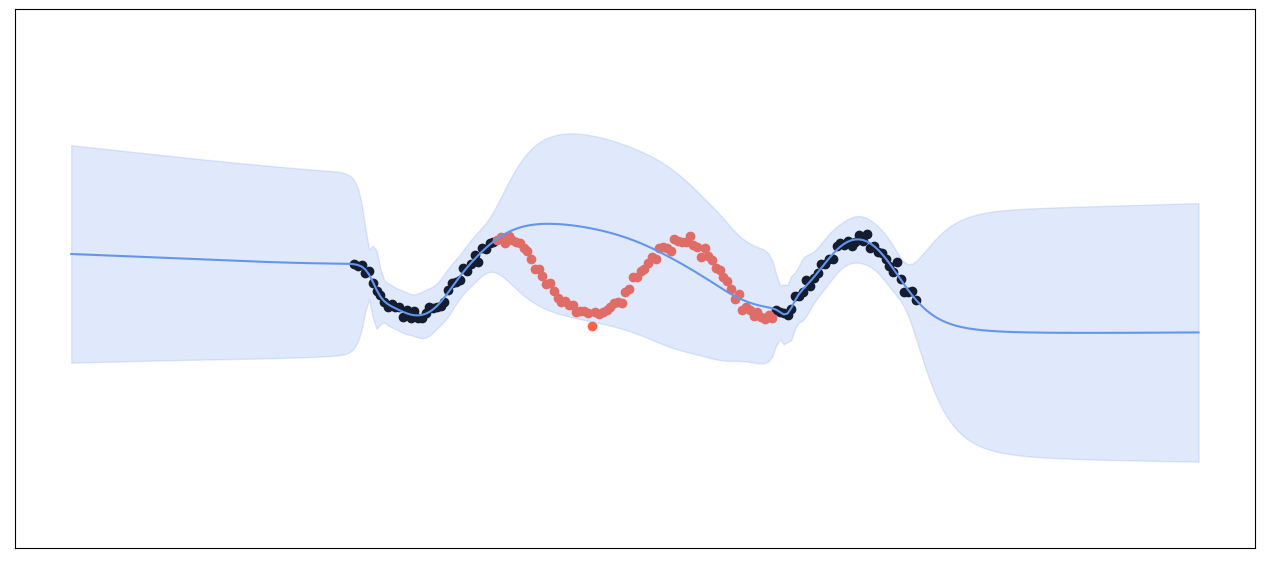

Initializing inducing classes with 1 different classes
Iteration  0
Validation NLL: 2.8537681102752686
Iteration  100
Validation NLL: 2.390230655670166
Iteration  200
Validation NLL: 2.245293140411377
Iteration  300
Validation NLL: 2.2161900997161865
Iteration  400
Validation NLL: 2.189143657684326
Iteration  500
Validation NLL: 2.166611671447754
Iteration  600
Validation NLL: 2.1485273838043213
Iteration  700
Validation NLL: 2.134312629699707
Iteration  800
Validation NLL: 2.1230669021606445
Iteration  900
Validation NLL: 2.1139023303985596
Iteration  1000
Validation NLL: 2.10602068901062
Iteration  1100
Validation NLL: 2.098705768585205
Iteration  1200
Validation NLL: 2.0912582874298096
Iteration  1300
Validation NLL: 2.0828518867492676
Iteration  1400
Validation NLL: 2.0727181434631348
Iteration  1500
Validation NLL: 2.0616567134857178
Iteration  1600
Validation NLL: 2.051187038421631
Iteration  1700
Validation NLL: 2.0415186882019043
Iteration  1800
Validation NLL: 2.03235578536987

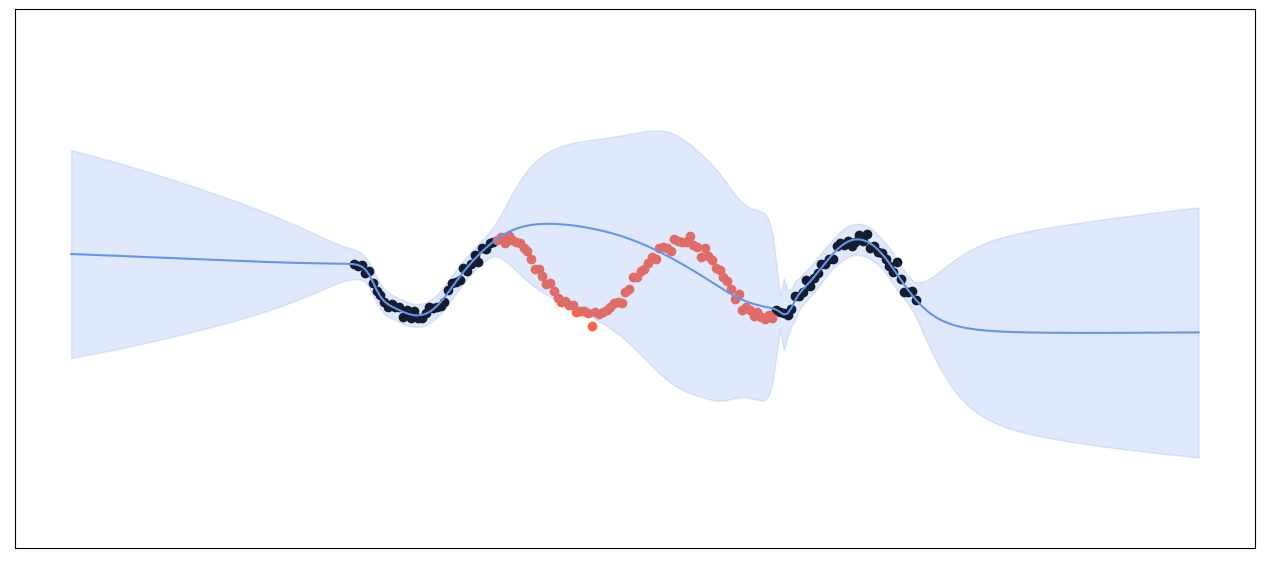

Initializing inducing classes with 1 different classes
Iteration  0
Validation NLL: 2.2713966369628906
Iteration  100
Validation NLL: 1.9592926502227783
Iteration  200
Validation NLL: 1.876194953918457
Iteration  300
Validation NLL: 1.8189289569854736
Iteration  400
Validation NLL: 1.7778630256652832
Iteration  500
Validation NLL: 1.7414875030517578
Iteration  600
Validation NLL: 1.7079582214355469
Iteration  700
Validation NLL: 1.6766153573989868
Iteration  800
Validation NLL: 1.6471905708312988
Iteration  900
Validation NLL: 1.6195961236953735
Iteration  1000
Validation NLL: 1.5938485860824585
Iteration  1100
Validation NLL: 1.5700379610061646
Iteration  1200
Validation NLL: 1.5483136177062988
Iteration  1300
Validation NLL: 1.5288784503936768
Iteration  1400
Validation NLL: 1.511986255645752
Iteration  1500
Validation NLL: 1.4979405403137207
Iteration  1600
Validation NLL: 1.4870942831039429
Iteration  1700
Validation NLL: 1.4798493385314941
Iteration  1800
Validation NLL: 1.4766560

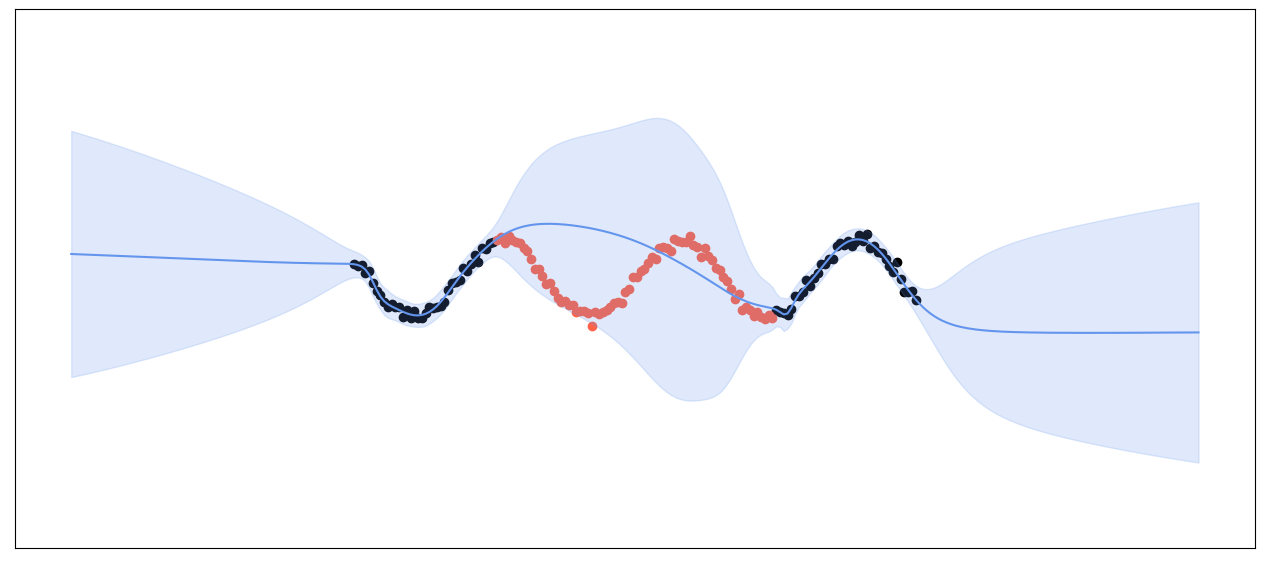

In [65]:
for m in Ms:
    Z = kmeans2(train_dataset.inputs, m, 
            minit="points", seed=params["seed"])[0]
    valla = VaLLARegression(
        create_ad_hoc_mlp(f),
        Z,
        alpha=params["bb_alpha"],
        prior_std=prior_std,
        log_variance=log_variance,
        #backend = backend,
        num_data=train_dataset.inputs.shape[0],
        output_dim=1,
        track_inducing_locations=True,
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    #valla.freeze_ll()
    #valla.freeze_prior()
    opt = torch.optim.Adam(valla.parameters(), lr=0.001)

    loss, val_loss = fit(
        valla,
        train_loader,
        opt,
        val_generator = val_loader,
        val_steps = 100,
        val_metrics= Regression,
        use_tqdm=False,
        return_loss=True,
        iterations=20000,
        device=params["device"],
    )
    distribution_plot(valla.predict_f, "VaLLA_val_M={}".format(m))

Initializing inducing classes with 1 different classes


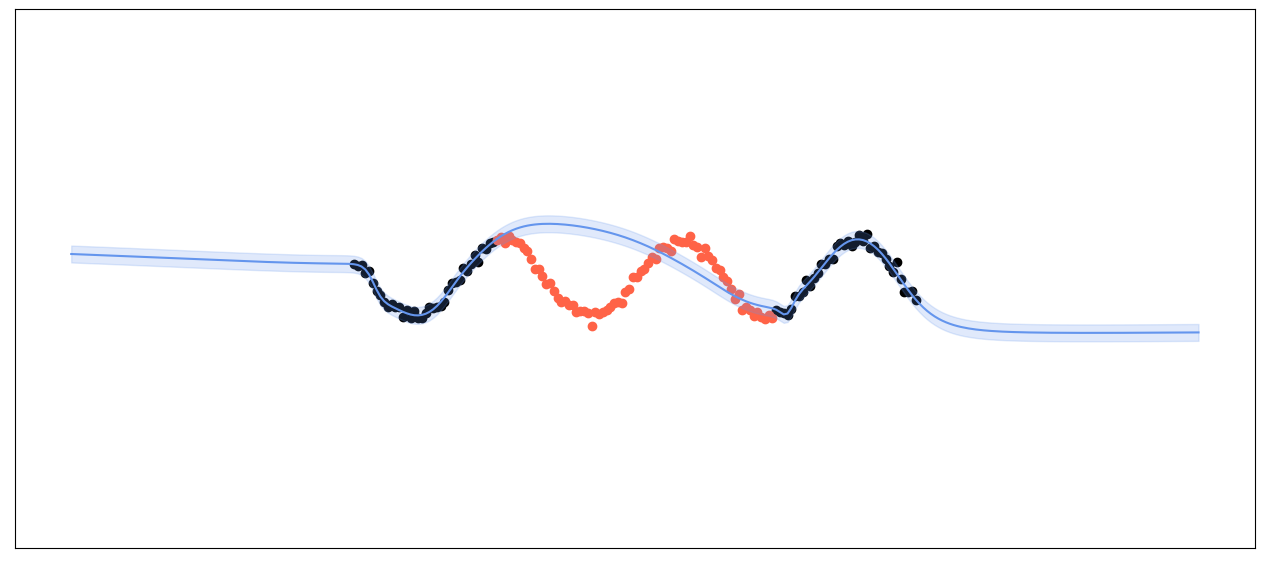

Initializing inducing classes with 1 different classes


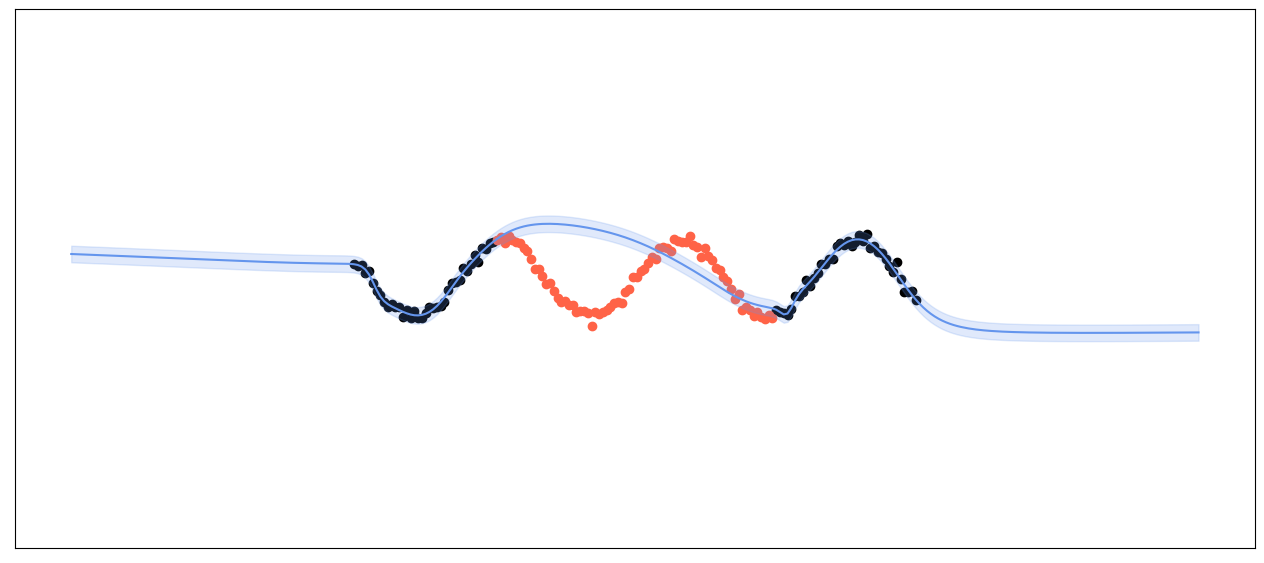

Initializing inducing classes with 1 different classes


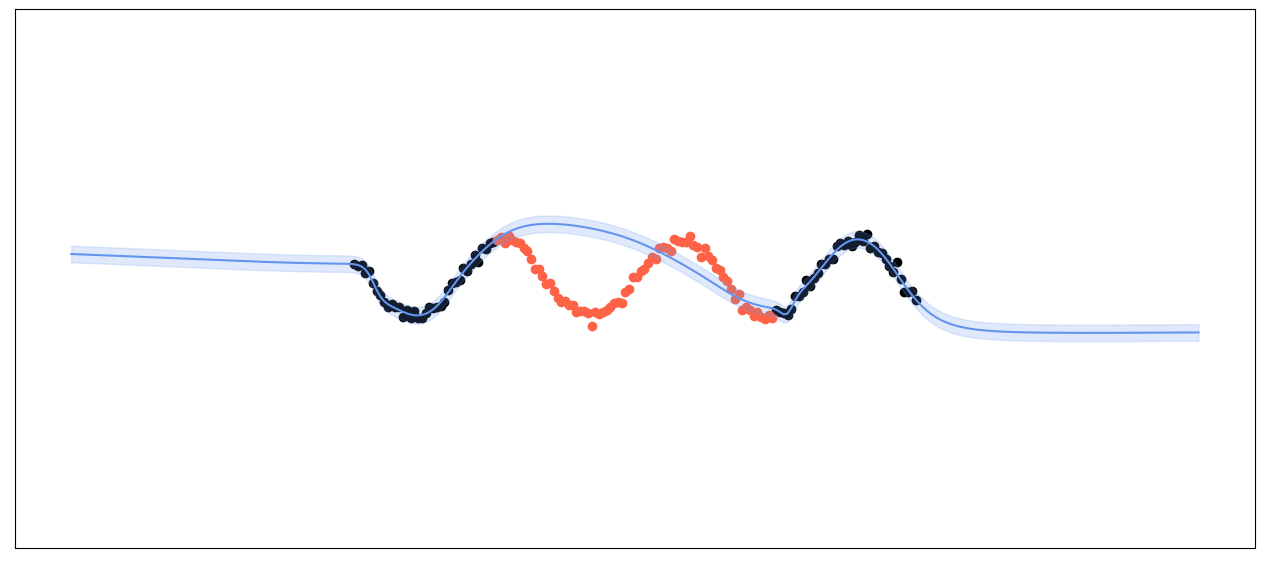

Initializing inducing classes with 1 different classes


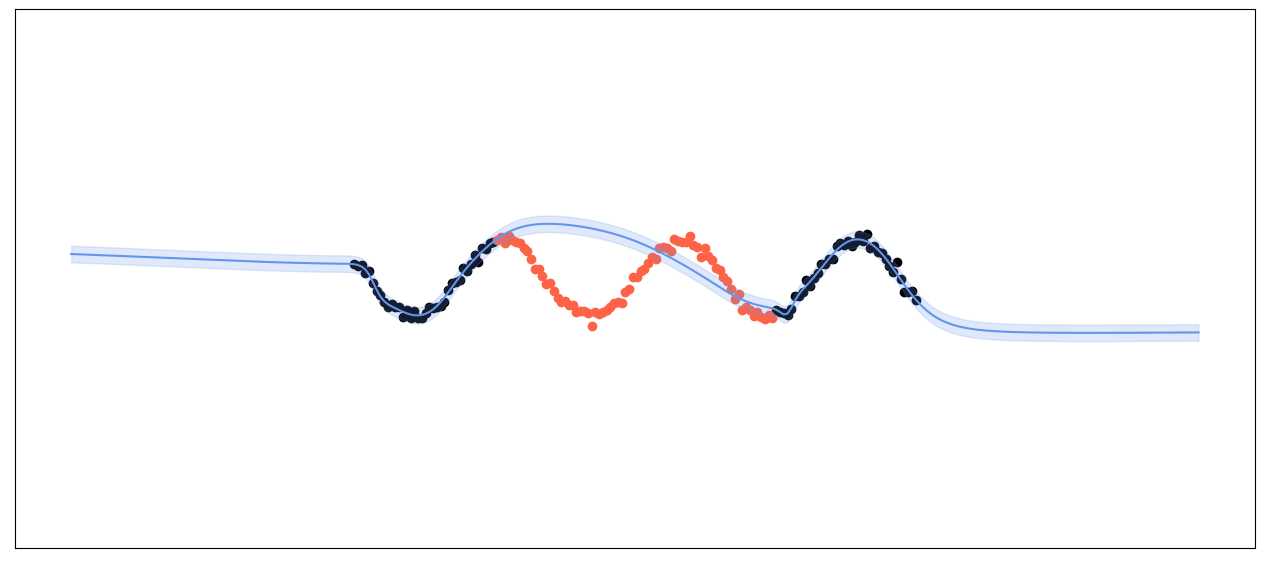

In [66]:
for m in Ms:
    Z = kmeans2(train_dataset.inputs, m, 
            minit="points", seed=params["seed"])[0]
    valla = VaLLARegression(
        create_ad_hoc_mlp(f),
        Z,
        alpha=params["bb_alpha"],
        prior_std=prior_std,
        log_variance=log_variance,
        #backend = backend,
        num_data=train_dataset.inputs.shape[0],
        output_dim=1,
        track_inducing_locations=True,
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    #valla.freeze_ll()
    #valla.freeze_prior()
    opt = torch.optim.Adam(valla.parameters(), lr=0.001)

    loss, val_loss = fit(
        valla,
        train_loader,
        opt,
        #val_generator = val_loader,
        #val_steps = 100,
        #val_metrics= Regression,
        use_tqdm=False,
        return_loss=True,
        iterations=20000,
        device=params["device"],
    )
    distribution_plot(valla.predict_f, "VaLLA_val2_M={}".format(m))